In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

In [2]:
df_train = pd.read_csv('../Data/Cleaned/Training.csv')
df_valid = pd.read_csv('../Data/Cleaned/Calibration.csv')

In [3]:
df_train.shape

(19920, 29)

Z1_IB_5_N1          Z1_IB_10_N1           Z3_IB_4_N1

ECI_IB_4_N1         ECI_IB_5_N1           

Z1_IB_10_N1         Z3_IB_8_N1           Z1_IB_5_N1  

In [4]:
#### Removed Highly colinear column -- .85

In [5]:
#drop_cols = ['Z1_IB_10_N1','Z3_IB_4_N1','ECI_IB_5_N1', 'Z3_IB_8_N1', 'Z1_IB_5_N1']

In [6]:
#df_train.drop(columns=drop_cols, axis=1, inplace=True)
#df_valid.drop(columns=drop_cols, axis=1, inplace=True)

In [7]:
predictors = df_train.drop(columns='class').columns

X_train = df_train[predictors]
Y_train = df_train['class']

X_calib = df_valid[predictors]
Y_calib = df_valid['class']

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score 
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, average_precision_score

In [20]:
def converttonum(Y_train = None,Y_calib = None):
    
    return LabelEncoder().fit_transform(Y_train),LabelEncoder().fit_transform(Y_calib)

In [12]:
def modelfit(pip, x_train, y_train, x_test, y_test, predictors):
    
    y_train, y_test = converttonum(y_train, y_test)
    
    #Fit the algorithm on the data
    pip.fit(x_train, y_train)
        
    #Predict training set:
    pred = pip.predict(x_test)
    
    
    cm = confusion_matrix(y_test, pred)

    #print(f'F1-score: {f1_score(y_test, pred)}')
    print(f'Precision: {100*round(precision_score(y_test, pred),4)}%')
    print(f'Recall: {100*round(recall_score(y_test, pred),4)}%')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N','P'])
    disp = disp.plot(include_values=True)

    plt.show()

In [13]:
def create_pipeline(scale, model,over=None, under=None, resample=None, pca=None):
    if resample == None:
        steps = [('std',scale), ('over', over), ('under', under), ('pca', pca), ('model', model)]
    else:
        steps = [('std',scale), ('smotetomek', resample), ('pca', pca), ('model', model)]
    return Pipeline(steps=steps)

Precision: 6.890000000000001%
Recall: 33.45%


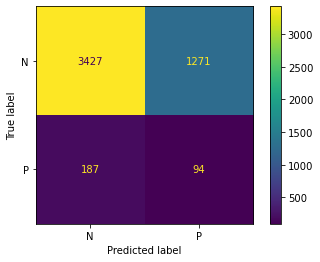

In [14]:
gbm_optimized = GradientBoostingClassifier(learning_rate=0.05, n_estimators=80, max_depth=11, 
                                 min_samples_split=800, min_samples_leaf=50,subsample=0.75, random_state=10)

scale = StandardScaler()
over = SMOTE()
under = RandomUnderSampler()
pca = PCA(n_components=26)
#col_trans = make_column_transformer((OrdinalEncoder(), ['Pb_NO_PCR_V']))
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

pipeline = create_pipeline(scale, gbm_optimized, over, under, resample, pca)

modelfit(pipeline, X_train, Y_train, X_calib, Y_calib,predictors)

### *Tunning the model based on Precision and Recall*

In [17]:
from sklearn.metrics import precision_recall_curve

In [15]:
y_scores = pipeline.predict_proba(X_calib)[:,1]

In [23]:
_, Y_calib_num = converttonum(Y_train, Y_calib)

In [24]:
p, r, thresholds = precision_recall_curve(Y_calib_num, y_scores)

Text(0, 0.5, 'precision')

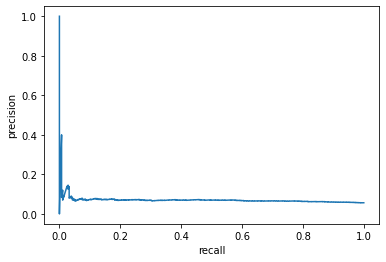

In [29]:
plt.plot(r,p)
plt.xlabel('recall')
plt.ylabel('precision')

#### *Graphical Performance tunning*

#### Removing outliers drops the performance